# Question 2:  Pose Graph Optimization for 2D SLAM

## Objective
A robot is travelling in a oval trajectory. It is equipped with wheel odometry for odometry information and RGBD sensors for loop closure information. Due to noise in wheel odometry it generates a noisy estimate of the trajectory. Our task is to use loop closure pairs to correct the drift.

We pose this problem as a graph optimization problem. In our graph, poses are the vertices and constraints are the edges. 

## Given: 
In practical scenarios, we'd obtain the following from our sensors after some post-processing:

1. Initial position
2. Odometry Contraints/Edges: This "edge" information tells us relative transformation between two nodes. These two nodes are consecutive in the case of Odometry but not in the case of Loop Closure (next point).
3. Loop Closure Contraints/Edges: Remember that while optimizing, you have another kind of "anchor" edge as you've seen in 1. solved example.

You have been given a text file named `edges.txt` (in `data/`) which has all the above 3 and it follows G2O's format (as explained in class, [link here](https://saishubodh.notion.site/G2O-Edge-Types-d9f9ff63c77c4ceeb84b1e49085004e3) ). The ground truth is `gt.txt`.

In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import helpers
from slam import get_residual, get_my_jacob, get_jax_jacob, calc_init_poses, LM


## Steps:

### Part 1

Using the following motion model, you have to first generate the "initialization" for all the poses/vertices using the "Given" information. Just like in the 1D case.
$$x_{k+1} = x_{k} + \Delta x_{(k,k+1)} \cos(\theta_k) - \Delta y_{(k,k+1)} \sin(\theta_k) \\
y_{k+1} = y_{k} + \Delta y_{(k,k+1)} \cos(\theta_k) + \Delta x_{(k,k+1)} \sin(\theta_k) \\
\theta_{k+1} = \theta_{k}+  \Delta \theta_{(k,k+1)} \tag{3}$$

Even the loop closure nodes are related by the above model, except that it need not necessarily be consecutive notes k and k+1.

Save this initial trajectory as `edges-poses.g2o`.

If you plot the initialized poses using odometry information, you need to get as the right plot below (this is the "noisy trajectory"): (Left one is the ground truth)
![robot-poses-MR-P1.png](../misc/robot-poses-MR-P1.png)

(Use `draw()` helper function or `g2o_viewer` or `EVO`)

Estimate using odometry


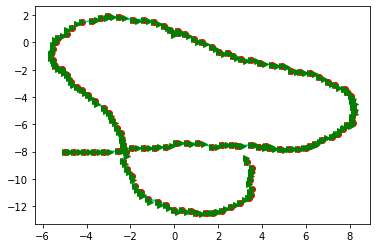

In [2]:

EDGES_FILE = '../data/edges.txt'
EDGES_POSES_FILE = '../data/edges-poses.g2o'

nodes, edges = helpers.read_data(EDGES_FILE)
fixed = nodes[:, 0]
poses = calc_init_poses(fixed, edges)
print("Estimate using odometry")
helpers.draw_one(poses[:, 0], poses[:, 1], poses[:, 2])
helpers.write_edges_poses(EDGES_POSES_FILE, EDGES_FILE, poses)


## Part 2

Now calculate the residual and the Jacobian and update your parameters using LM.

Use LM algorithm. Regarding Jacobian calculation, you can use `jax`'s `jacobian` as part of your main code. However, you still have to separately calculate it analytically and verify if it matches with `jax`'s `jacobian` using frobenius norm `frobNorm()`). Calculation and verification is compulsory, but it is your choice to use whichever as part of your optimization. Use whichever is faster. You can also visualise your Jacobian and see the structure of the matrix (just use `plt.imshow`).

**Regarding LM iterations, stopping criterion, information matrix values.**

1. As your iterations proceed, you have to print relevant information (iteration number and error value: [$F = \frac{1}{2}  \mathbf{f}^{\top} \mathbf{\Omega} \mathbf{f} $ (notes on non-linear LS)](https://saishubodh.notion.site/From-linear-algebra-to-non-linear-weighted-least-squares-optimization-13cf17d318be4d45bb8577c4d3ea4a02#32832dee7d6c4ab49581463d9b784f21) at every step).

2. You have to show the plots (ground truth, noisy & optimized: all 3 in a single plot) at every 10 steps or so.

3. You could start with information values of 500 for odom edges, 700 for loop closure edges, 1000 for anchor edge (same for all dimensions). However, you have to _heavily_ experiment with these values. (Given that you somehow know loop closure information is way more reliable than odometry.). At the end of your experimentation, your error $F = \frac{1}{2}  \mathbf{f}^{\top} \mathbf{\Omega} \mathbf{f} $ should by < 40. Explain your experimentation in detail using tables/plots etc if necessary.
    
Do not worry if you're not getting a perfect trajectory. Our parametrization was oversimplified for the sake of this project. With that being said, it is possible to get the error down to < 40 and make it at least look like an oval shaped trajectory, even if it doesn't perfectly resemble the ground truth. However, using `g2o` (seen later on), you will be getting a close to ground truth trajectory.

**Tip**

Be sure to make your code modular and implement this in various stages. It will help you debug errors. Feel free to create helper functions in other files, just be sure to submit those as well. 

You are free to optimise your code using numba/Jax/torch if you wish, just ensure that you are not using any built in functions for any of the steps. It is only compulsory to verify your Jacobian using Jax.

Comparing Jacobians
Frobenius norm between my jacobian and jax jacobian is: 0.0


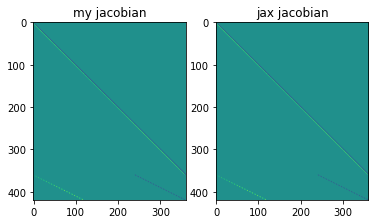

In [3]:
def compare_jacobs():
    my_jacob = get_my_jacob(poses, edges, fixed)
    jax_jacob = get_jax_jacob(poses, edges, fixed)

    print("Comparing Jacobians")
    helpers.frobNorm(my_jacob, jax_jacob, "my jacobian", "jax jacobian")
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(my_jacob)
    ax[1].imshow(jax_jacob)
    ax[0].set_title('my jacobian')
    ax[1].set_title('jax jacobian')
    plt.show()

compare_jacobs()


Iteration 0: Error: 913388.75


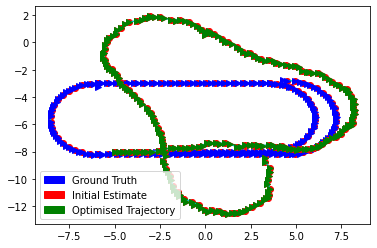

Iteration 1: Error: 142676.125
Iteration 2: Error: 4099.98779296875
Iteration 3: Error: 1083.9229736328125
Iteration 4: Error: 1033.9820556640625
Iteration 5: Error: 1024.1834716796875
Iteration 6: Error: 1015.8997192382812
Iteration 7: Error: 1008.9548950195312
Iteration 8: Error: 1001.041015625
Iteration 9: Error: 995.11962890625
Iteration 10: Error: 989.3616333007812


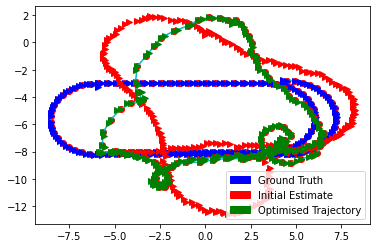

Iteration 11: Error: 985.55615234375
Iteration 12: Error: 982.5374755859375
Iteration 13: Error: 980.2596435546875
Iteration 14: Error: 978.489990234375
Iteration 15: Error: 977.0687255859375
Iteration 16: Error: 975.8880615234375
Iteration 17: Error: 974.9343872070312
Iteration 18: Error: 974.0856323242188
Iteration 19: Error: 973.402099609375
Iteration 20: Error: 972.7662963867188


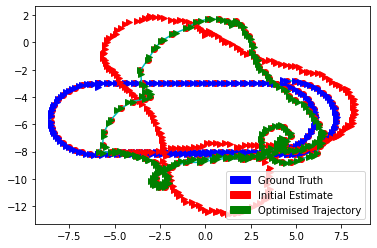

Iteration 21: Error: 972.2520141601562
Iteration 22: Error: 971.7636108398438
Iteration 23: Error: 971.3679809570312
Iteration 24: Error: 970.9886474609375
Iteration 25: Error: 970.6785888671875
Iteration 26: Error: 970.3826904296875
Iteration 27: Error: 970.1384887695312
Iteration 28: Error: 969.9065551757812
Iteration 29: Error: 969.7138061523438
Iteration 30: Error: 969.5321044921875


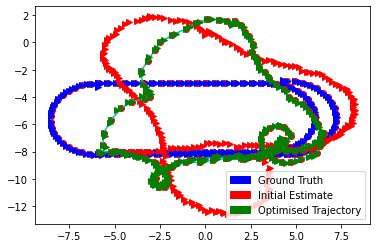

Iteration 31: Error: 969.3795166015625
Iteration 32: Error: 969.2367553710938
Iteration 33: Error: 969.1162719726562
Iteration 34: Error: 969.0043334960938
Iteration 35: Error: 968.9095458984375
Iteration 36: Error: 968.8211669921875
Iteration 37: Error: 968.7463989257812
Iteration 38: Error: 968.6768188476562
Iteration 39: Error: 968.6178588867188
Iteration 40: Error: 968.5626220703125


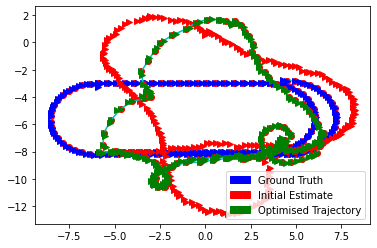

Iteration 41: Error: 968.5164184570312
Iteration 42: Error: 968.4735107421875
Iteration 43: Error: 968.4370727539062
Iteration 44: Error: 968.4035034179688
Iteration 45: Error: 968.3744506835938
Iteration 46: Error: 968.3480834960938
Iteration 47: Error: 968.3248291015625
Iteration 48: Error: 968.3043823242188
Iteration 49: Error: 968.2865600585938
Iteration 50: Error: 968.2701416015625


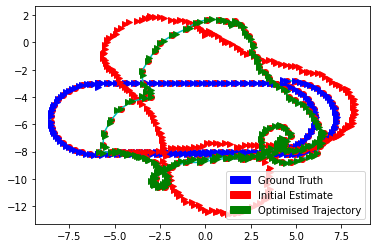

Iteration 51: Error: 968.2565307617188
Iteration 52: Error: 968.2437744140625
Iteration 53: Error: 968.232421875
Iteration 54: Error: 968.2222290039062
Iteration 55: Error: 968.2135009765625
Iteration 56: Error: 968.2059936523438
Iteration 57: Error: 968.1986694335938
Iteration 58: Error: 968.1932983398438
Iteration 59: Error: 968.1871948242188
Iteration 60: Error: 968.1823120117188


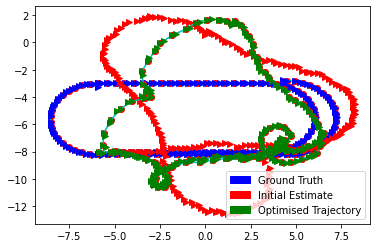

Iteration 61: Error: 968.1787109375
Iteration 62: Error: 968.1747436523438
Iteration 63: Error: 968.1708984375
Iteration 64: Error: 968.16845703125
Iteration 65: Error: 968.1655883789062
Iteration 66: Error: 968.1636352539062
Iteration 67: Error: 968.1615600585938
Iteration 68: Error: 968.1597290039062
Iteration 69: Error: 968.1576538085938
Iteration 70: Error: 968.1568603515625


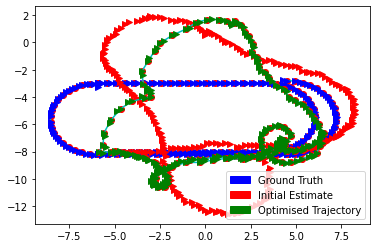

Iteration 71: Error: 968.1549072265625
Iteration 72: Error: 968.1541137695312
Iteration 73: Error: 968.1532592773438
Iteration 74: Error: 968.152099609375
Iteration 75: Error: 968.1515502929688
Iteration 76: Error: 968.1507568359375
Iteration 77: Error: 968.14990234375
Iteration 78: Error: 968.1493530273438
Iteration 79: Error: 968.1488037109375
Iteration 80: Error: 968.148681640625


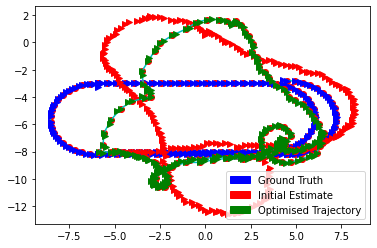

Iteration 81: Error: 968.1483154296875
Iteration 82: Error: 968.1477661132812
Iteration 83: Error: 968.1474609375
Iteration 84: Error: 968.1472778320312
Iteration 85: Error: 968.1473388671875
Iteration 86: Error: 968.1466674804688
Iteration 87: Error: 968.146728515625
Iteration 88: Error: 968.1463012695312
Iteration 89: Error: 968.1458129882812
Iteration 90: Error: 968.14599609375


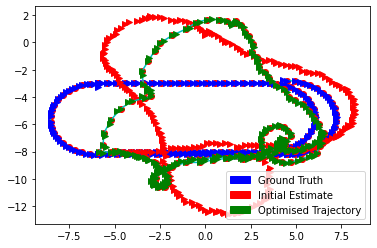

Iteration 91: Error: 968.1455688476562
Iteration 92: Error: 968.1464233398438
Iteration 93: Error: 968.1459350585938
Iteration 94: Error: 968.146240234375
Iteration 95: Error: 968.1454467773438
Iteration 96: Error: 968.1456298828125
Iteration 97: Error: 968.1455688476562
Iteration 98: Error: 968.1456298828125
Iteration 99: Error: 968.1452026367188
Final Error:  968.14545


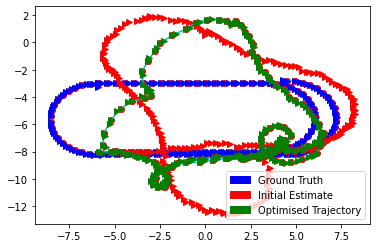

In [4]:
lm = LM(poses,edges, fixed, 1, 100, 1e-6)
poses_arr, error_arr = lm.optimize()

## Part 3

- Write about the residuals you computed, its structure and shape. Also explain the structure of the Jacobian and its shape (Express the shape in terms of the number of vertices, loop constraints, and such, not exact numbers). 
- Write about the optimization process and any observations using intermediate plots and such. 

## Part 4

Write the final optimised trajectory as a g2o file. You can do this alongside any of the earlier parts.